[原版（英文）图书地址](https://www.oreilly.com/library/view/feature-engineering-for/9781491953235/)


**代码修改和整理**：[黄海广](https://github.com/fengdu78)，原文修改成jupyter notebook格式，并增加和修改了部分代码，测试全部通过，所有数据集已经放在[百度云](data/README.md)下载。

**备注**：请等待，数据集已经下载，代码还未测试，先放上翻译。

# 九、回到特征：将它们放到一起

当第一次看到图1-1 中从数据到结果的路径时，很可能会无所适从。纵贯本书，我们的重点在于介绍特征工程的基本原则，我们使用的是玩具模型和简单明了的数据集，这些例子是有意设计成有说明性和启发性的。

机器学习的常见例子是展示最理想的情况和最佳结果，这掩盖了本书中描述的路径中的艰辛。既然基础已经打好，我们就离开模拟数据的简单世界，投入到使用真实的、结构化数据集的特征工程中。在前进的每个阶段中，我们都会研究如何从原始数据生成特征，如何进行特征转换，以及特征工程中需要何种权衡取舍。

先说一下，这个综合示例的目标不是为数据集建立最好的模型，而是演示一下本书中几种技术的实际应用，以及如何更加深入地研究一下各种技术是否可以为建模过程提供价值。

## 基于物品的协同过滤

我们的任务是使用Microsoft Academic Graph数据集的子样本为学术论文构建推荐器。 对于正在搜索引文但没使用Google学术搜索的所有人来说，这应该非常方便。 以下是有关数据集的一些相关统计信息：

### Microsoft Academic Graph 数据集
这个数据集包含 166 192 182 篇论文，可经由 Open Academic Graph 获取，
- 只能用于研究目的。
- 完整数据集的大小是 104GB。
- 每条观测有 18 个变量用以标识论文，包括论文题目、论文摘要、作者姓名、关键字和研究领域。

**备注**：这个数据集已经下载并处理好了，如果只是为了跑通本文代码，就不需要再下载了，本文数据我已经放到了[百度云](data/)

这个数据集被设计成易于使用数据库存储和读取。对于机器学习模型来说，它可能不够整洁，需要做一些基本的数据整理。有些教师喜欢省略这个步骤，让学生直接建模并得到结果，但我们可不这么做，我们一切都从头开始。

第一步是将一些变量整理为正确的形式，建立一个基于项目的协同过滤器，看看能否快速有效地找到那些非常相似的论文。

### 基于物品的协同过滤的起源
这种方法最初是由 Amazon 公司开发的，作为基于用户的商品推荐算法的一种改进。Sarawar 等人详细介绍了将推荐算法从基于用户切换到基于物品的过程中的困难和收获(Sarawar et al. (2001))。

基于物品的协同过滤方法根据物品之间的相似程度来提供推荐。这项工作分为两个阶段： 首先找出物品之间的相似度评分，然后对所有评分进行排序，找到前 $N$ 个相似项目作为推荐。

### 建立基于物品的推荐器
基于物品的推荐器完成以下三项任务。

1.	生成关于“事物”或物品的信息。
2.	对所有物品进行评分，找出与某个项目“相似”的其他物品。
3.	返回评分排序 + 物品。

## 第一步：数据导入、清理和特征解析
与所有优秀的科学实验一样，我们从一个假设开始。在这个例子中，我们假定那些大约在同一时间而且在同一研究领域发表的论文对用户是最有用的。我们使用一种简单的方法从完整数据集的一个子样本中解析出这些字段。在生成了简单的稀疏数组后，我们在整个物品数组上运行基于物品的协同过滤器，看看能否得到满意的结果。

基于物品的协同过滤器使用相似度评分来比较物品。在这个例子中，余弦相似度可以在两个非零向量之间提供合理的比较。下面的例子使用的就是余弦距离，它是余弦相似度在正空间中的补集，即：

$$D_C(A,B)=1-S_C(A,B)$$
其中 $D_C$ 是余弦距离，而 $S_C$ 表示余弦相似度。

### 学术论文推荐器：简单方法
第一步就是导入和检查数据集。在例 9-1  中，我们先导入数据，然后选择出一些可用的字段，以此来开始实验。在保留的字段中仍然含有丰富的信息，如图 9-1 所示。

#### 例 9-1：导入并过滤数据

In [1]:
import pandas as pd

In [2]:
model_df = pd.read_json('data/mag_subset20K.txt', lines=True)

model_df.shape

(20000, 19)

In [3]:
model_df.columns

Index(['abstract', 'authors', 'doc_type', 'doi', 'fos', 'id', 'issue',
       'keywords', 'lang', 'n_citation', 'page_end', 'page_start', 'publisher',
       'references', 'title', 'url', 'venue', 'volume', 'year'],
      dtype='object')

In [4]:
# filter out non-English articles
# keep abstract, authors, fos, keywords, year, title
# model_df = model_df[model_df.lang == 'en'].drop_duplicates(
#     subset='title', keep='first').drop([
#         'doc_type', 'doi', 'id', 'issue', 'lang', 'n_citation', 'page_end',
#         'page_start', 'publisher', 'references', 'url', 'venue', 'volume'
#     ],
#                                        axis=1)
model_df = model_df.drop_duplicates(
    subset='title', keep='first').drop([
        'doc_type', 'doi', 'id', 'issue', 'n_citation', 'page_end',
        'page_start', 'publisher', 'venue', 'volume'
    ],
                                       axis=1)
model_df.shape

(20000, 9)

In [5]:
model_df.head(2)

,abstract,authors,fos,keywords,lang,references,title,url,year
0,A system and method for maskless direct write ...,NaN,"[Electronic engineering, Computer hardware, En...",NaN,en,"[354c172f-d877-4e60-a7eb-c1b1cf03ce4d, 76cf106...",System and Method for Maskless Direct Write Li...,[http://www.freepatentsonline.com/y2016/021111...,2015
1,NaN,[{'name': 'Ahmed M. Alluwaimi'}],"[Biology, Virology, Immunology, Microbiology]","[paratuberculosis, of, subspecies, proceedings...",en,NaN,The dilemma of the Mycobacterium avium subspec...,[http://www.omicsonline.org/proceedings/the-di...,2016


<center>图 9-1：Microsoft Academic Graph数据集的前两行</center>

从表 9-1 中可以非常清楚地看出，需要何种程度的数据整理才能将原始数据转换为更适合建模的形式。列表和字典便于数据存储，但如果不经过一些解包操作的话，就不够整洁，不能很好地适应机器学习（Wickham, 2014）。

<center>表9-1：model_df的数据概述</center>

|Field name|Description|Field type|# NaN|
|:-:|:-:|:-:|:-:|
|abstract|paper abstract|string	|4393|
|authors|author names and affiliations|list of dict, keys = name, org|1|
|fos|fields of study|list of strings|1733|
|keywords|keywords|list of strings|4294|
|title|paper title|string|0|
|year|published year|int|0|

在例 9-2 中，我们先重点关注两个字段，将它们从列表和整数转换为特征数组，如图 9-2所示。

####  例 9-2：协同过滤阶段 1：建立物品特征矩阵

In [6]:
unique_fos = sorted(list({ feature
                          for paper_row in model_df.fos.fillna('0')
                          for feature in paper_row }))

unique_year = sorted(model_df['year'].astype('str').unique())

len(unique_fos + unique_year)

9325

In [7]:
model_df.shape[0] - pd.isnull(model_df['fos']).sum()

13251

In [8]:
len(unique_fos)

9150

In [9]:
import random
[unique_fos[i] for i in sorted(random.sample(range(len(unique_fos)), 15)) ]

['Ancient history',
 'Dentistry',
 'Functional residual capacity',
 'Hierarchical database model',
 'Irrigation',
 'Mycology',
 'Noise temperature',
 'Powder diffraction',
 'Random test generator',
 'Reaction intermediate',
 'Rotating wave approximation',
 'Schwarz lemma',
 'Service delivery framework',
 'Social environment',
 'Transforming growth factor']

In [10]:
def feature_array(x, unique_array):
    row_dict = {}
    for i in x.index:
        var_dict = {}
        
        for j in range(len(unique_array)):
            if type(x[i]) is list:
                if unique_array[j] in x[i]:
                    var_dict.update({unique_array[j]: 1})
                else:
                    var_dict.update({unique_array[j]: 0})
            else:    
                if unique_array[j] == str(x[i]):
                    var_dict.update({unique_array[j]: 1})
                else:
                    var_dict.update({unique_array[j]: 0})
        
        row_dict.update({i : var_dict})
    
    feature_df = pd.DataFrame.from_dict(row_dict, dtype='str').T
    
    return feature_df

In [11]:
%time year_features = feature_array(model_df['year'], unique_year)

Wall time: 1min


In [12]:
%time fos_features = feature_array(model_df['fos'], unique_fos)

from sys import getsizeof
print('Size of fos feature array: ', getsizeof(fos_features))

Wall time: 58min 30s
Size of fos feature array:  5856418904


In [17]:
year_features.shape[1] + fos_features.shape[1]

9325

In [18]:
# now looking at 10399 x  7760 array for our feature space

%time first_features = fos_features.join(year_features).T

first_size = getsizeof(first_features)

print('Size of first feature array: ', first_size)

Wall time: 24.9 s
Size of first feature array:  5969031694


We will start with a simple example of building a recommender with just a few fields, building sparse arrays of available features to calculate for the cosine similary between papers. We will see if reasonably similar papers can be found in a timely manner.

In [19]:
first_features.shape

(9325, 20000)

In [20]:
first_features.head()

,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0-10 V lighting control,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1-planar graph,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/N expansion,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10G-PON,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<center>图 9-2：first_features 的头部——原始数据集中观测（论文）的索引是列，特征是行</center>

我们成功地将一个较小的数据集（大约 1 万行原始数据）转换成了 2.5GB 的特征。但对于需要快速迭代的数据探索过程来说，这种方法太笨重了。我们需要更快速的方法，使得出的特征占用更少的计算资源和实验时间。

稍安勿躁，不妨先看一下，现在这种特征在下一阶段能为我们做出多么好的推荐（见例 9-3）。我们定义“好”的推荐就是与输入相似的论文。


####  例 9-3   协同过滤阶段 2：查找相似物品

In [42]:
# from scipy.spatial.distance import cosine


# def item_collab_filter(features_df):
#     item_similarities = pd.DataFrame(
#         index=features_df.columns, columns=features_df.columns)
#     item_similarities.fillna(0)#后面添加的，把nan填充为0
#     for i in features_df.columns:
#         for j in features_df.columns:
#             item_similarities.loc[i][j] = 1 - cosine(features_df[i],
#                                                      features_df[j])

#     return item_similarities

In [53]:
from scipy.spatial.distance import cosine


def item_collab_filter(features_df):
    item_similarities = pd.DataFrame(
        index=features_df.columns, columns=features_df.columns)
    for i in features_df.columns:
        for j in features_df.columns:
            item_similarities.loc[i][j] = 1 - cosine(
                features_df[i].tolist(),
                features_df[j].tolist())  #这里有改动，增加了.tolist()

    return item_similarities

In [54]:
first_features

,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0-10 V lighting control,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1-planar graph,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/N expansion,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10G-PON,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14-3-3 protein,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2-choice hashing,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20th-century philosophy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2D Filters,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2D computer graphics,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
%time first_items = item_collab_filter(first_features.loc[:, 0:1000])
#这一步时间非常长，大概要1小时

Wall time: 1h 3min 18s


Why does it take so long for us to calculate the item similarities using only two features? We are taking the dot product of a 10,399 × 1,000 我们只是使用两个特征来计算项目相似度，为什么计算时间如此之长？因为我们使用了嵌套 for 循环来计算一个 10 399×1000 的矩阵的点积。如果向模型中添加了更多观测，那每次循环的时间还会增加。注意，我们只筛选出了英文论文，这只是整个可用数据集的一个子集。当得到一个差不多“好”的结果时，还需要回到更大的数据集合上进行测试，看看这是不是最好的结果。

怎么才能做得更快一些呢？因为每次只需要一个结果，所以可以修改一下函数，指定我们需要的前几个结果的数量，每次只计算一个项目。我们以后会这么做，因为需要持续改进实验。眼下还是使用全特征空间，理解一下在实际数据集上使用暴力算法时迭代造成的影响。

要得到好的推荐，需要一种更好的特征转换方法。我们有足够的观测来改进吗？让我们绘制一幅热图（见例 9-4），看看是否有彼此相似的论文。结果显示在图 9-3 中。


#### 例 9-4:论文推荐热图

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

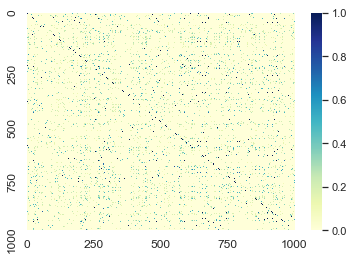

In [57]:
sns.set()
ax = sns.heatmap(
    first_items.fillna(0),
    vmin=0,
    vmax=1,
    cmap="YlGnBu",
    xticklabels=250,
    yticklabels=250)
ax.tick_params(labelsize=12)

<center>图 9-3：相似论文热图，基于两个初始特征：发表年份和研究领域</center>

颜色较暗的像素表示彼此相似的项目。黑色对角线说明了余弦相似度能正确地表示出每篇论文都与它本身是最相似的。但是，因为有个特征中有很多 NaN 值，所以对角线是断断续续的。可以看出，尽管多数项目是彼此不相似的（这说明我们的数据集来源非常广泛），但还是有一些相似度评分很高的候选值。定性地看，这些可能是好的推荐，也可能不是， 但至少说明了我们的方法不是一无是处。

例 9-5 给出了将物品相似度转换为推荐的方法。值得庆幸的是：我们还有大量可用的特征，改进空间非常大。

#### 例 9-5：基于物品的协同过滤推荐

In [58]:
def paper_recommender(paper_index, items_df):
    print('Based on the paper: \nindex = ', paper_index)
    print(model_df.iloc[paper_index])
    top_results = items_df.loc[paper_index].sort_values(
        ascending=False).head(4)
    print('\nTop three results: ')
    order = 1
    for i in top_results.index.tolist()[-3:]:
        print(order, '. Paper index = ', i)
        print('Similarity score: ', top_results[i])
        print(model_df.iloc[i], '\n')
        if order < 5: order += 1

In [59]:
paper_recommender(2, first_items)

Based on the paper: 
index =  2
abstract                                                    NaN
authors       [{'name': 'Jovana P. Lekovich', 'org': 'Weill ...
fos                                                         NaN
keywords                                                    NaN
lang                                                         en
references                                                  NaN
title         Should endometriosis be an indication for intr...
url           [http://www.fertstert.org/article/S0015-0282(1...
year                                                       2015
Name: 2, dtype: object

Top three results: 
1 . Paper index =  71
Similarity score:  1.0
abstract                                              NaN
authors                    [{'name': 'Harold S. Wilson'}]
fos                                                   NaN
keywords                                              NaN
lang                                                  NaN
references   

好消息是返回的最相似论文就是我们要找的论文，坏消息是即使我们使用了选定的特征，另外两篇论文似乎与我们的搜索初衷相去甚远。

“是的，是的，”你可能会说，“但现在是大数据时代，这会解决我们的问题！我们难道不能通过更多数据找出更好的结果吗？”可能会，但即使大数据也不能弥补糟糕的数据和特征选择所造成的恶果。

![](images/chapter9/9-4.png)
<center>图 9-4：机器学习(https://xkcd.com/1838/)</center>
现在的暴力方法太慢了，远算不上是智能的、迭代的特征工程。下面试验一下新的特征工程技术，看看是否能提高计算速度，找到更合适的特征和搜索结果的更好方式。

## 第二步：更多特征工程和更智能的模型

最初的方法是创建一个巨大的、稀疏的数组，然后通过一个筛选器暴力求解。有多种方式可以改进这种方法。下一步的重点是使用更好的技术来处理两个初始特征，并修改基于物品的协同过滤方法来加快迭代。

首先，在假设中的两个变量上，试验一下本书介绍过的精彩的特征工程技巧。在更加深入地研究了特征之后，我们可以选择那些适合每种变量的技术，将变量转换为适合推荐系统的“更好”的特征。


### 学术论文推荐器：第2轮
先看出版年份。2.2.2 节（“Quantization or Binning”）中介绍了为什么使用原始计数作为特征不适合那些使用相似度度量的方法。例 9-6 和图 9-5 会研究如何对 year 进行转换，以使它更加适合我们选择的模型。

#### 例 9-6：等宽分箱 + 虚拟编码（第 1 部分）

In [60]:
print("Year spread: ", model_df['year'].min(), " - ", model_df['year'].max())
print("Quantile spread:\n", model_df['year'].quantile([0.25, 0.5, 0.75]))

Year spread:  1800  -  2017
Quantile spread:
 0.25    1992.0
0.50    2005.0
0.75    2012.0
Name: year, dtype: float64


Text(0,0.5,'Occurrence')

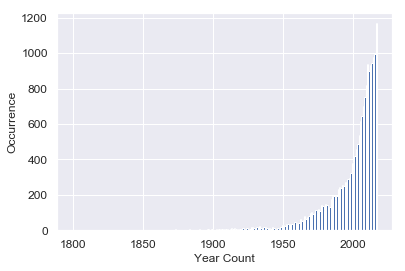

In [61]:
# plot years to see the distribution
fig, ax = plt.subplots()
model_df['year'].hist(ax=ax, bins= model_df['year'].max() - model_df['year'].min())
ax.tick_params(labelsize=12)
ax.set_xlabel('Year Count', fontsize=12)
ax.set_ylabel('Occurrence', fontsize=12)

<center>图 9-5：数据集中 10 000 多篇学术论文的原始出版年份分布</center>
从图 9-5 中的偏态分布来看，出版年份非常适合分箱操作。

我们将根据变量的取值范围来分箱，而不是唯一的特征值数量。为了进一步压缩特征空间，我们对分箱结果进行虚拟编码（见例 9-7）。Pandas 的内置函数可以完成这两项任务。这些方法的结果很容易解释，所以我们可以对转换后的特征做一个快速检查（见图 9-6），再进行后面的工作。

#### 例 9-7   定宽分箱 + 虚拟编码（第 2 部分）

In [62]:
# we'll base our bins on the range of the variable, rather than the unique number of features
model_df['year'].max() - model_df['year'].min()

217

In [63]:
# binning here (by 10 years)
bins = int(round((model_df['year'].max() - model_df['year'].min()) / 10))

temp_df = pd.DataFrame(index=model_df.index)
temp_df['yearBinned'] = pd.cut(model_df['year'].tolist(), bins, precision=0)

In [64]:
# now we only have as many bins as we created(grouping together by 10 years)
print('We have reduced from', len(model_df['year'].unique()), 'to',
      len(temp_df['yearBinned'].values.unique()),
      'features representing the year.')

We have reduced from 175 to 21 features representing the year.


In [65]:
X_yrs = pd.get_dummies(temp_df['yearBinned'])
X_yrs.head()

,"(1800.0, 1810.0]","(1810.0, 1820.0]","(1820.0, 1830.0]","(1830.0, 1839.0]","(1839.0, 1849.0]","(1849.0, 1859.0]","(1859.0, 1869.0]","(1869.0, 1879.0]","(1879.0, 1889.0]","(1889.0, 1899.0]",...,"(1918.0, 1928.0]","(1928.0, 1938.0]","(1938.0, 1948.0]","(1948.0, 1958.0]","(1958.0, 1968.0]","(1968.0, 1978.0]","(1978.0, 1987.0]","(1987.0, 1997.0]","(1997.0, 2007.0]","(2007.0, 2017.0]"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [66]:
X_yrs.columns.categories

IntervalIndex([(1800.0, 1810.0], (1810.0, 1820.0], (1820.0, 1830.0], (1830.0, 1839.0], (1839.0, 1849.0] ... (1968.0, 1978.0], (1978.0, 1987.0], (1987.0, 1997.0], (1997.0, 2007.0], (2007.0, 2017.0]]
              closed='right',
              dtype='interval[float64]')

Text(0,0.5,'Counts')

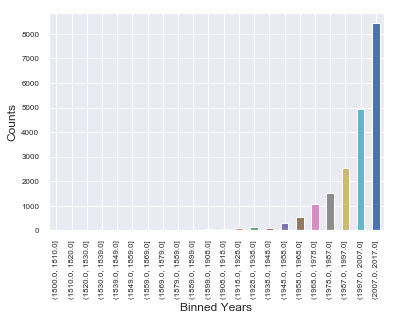

In [67]:
# let's look at the new distribution
fig, ax = plt.subplots()
X_yrs.sum().plot.bar(ax=ax)
ax.tick_params(labelsize=8)
ax.set_xlabel('Binned Years', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

<center>图 9-6：分箱之后新特征 X_yrs 的分布</center>

按照 10 年的宽度进行分箱，我们保留了原始变量中的基本分布。如果需要对其他分布进行分箱，可以修改一下分箱设置，改变变量在模型中的呈现方式。因为我们使用的是余弦相似度，所以这样做没有问题。下面接着处理模型中最初包含的另外一个特征。研究领域特征空间对初始模型的大小和处理时间有非常显著的影响。

检查一下已经完成的工作。通过解析字符串列表，我们在第一关中创建了一个“短语袋”。既然已经有了一个非常好用的稀疏数组，就应该使用这个更高效的数据类型来表示这个短语袋。例 9-8 演示了将 Pandas 数据框转换为 NumPy 稀疏数组之后对计算时间的影响。


#### 例 9-8:将短语袋从 pd.Series 转换为 NumPy 稀疏数组

In [68]:
unique_fos = sorted(list({ feature
                          for paper_row in model_df.fos.fillna('0')
                          for feature in paper_row }))

In [69]:
def feature_array(x, unique_array):
    row_dict = {}
    for i in x.index:
        var_dict = {}
        
        for j in range(len(unique_array)):
            if type(x[i]) is list:
                if unique_array[j] in x[i]:
                    var_dict.update({unique_array[j]: 1})
                else:
                    var_dict.update({unique_array[j]: 0})
            else:    
                if unique_array[j] == str(x[i]):
                    var_dict.update({unique_array[j]: 1})
                else:
                    var_dict.update({unique_array[j]: 0})
        
        row_dict.update({i : var_dict})
    
    feature_df = pd.DataFrame.from_dict(row_dict, dtype='str').T
    
    return feature_df

In [70]:
%time fos_features = feature_array(model_df['fos'], unique_fos)

Wall time: 57min 51s


In [71]:
fos_features.head(2)

,0,0-10 V lighting control,1-planar graph,1/N expansion,10G-PON,14-3-3 protein,2-choice hashing,20th-century philosophy,2D Filters,2D computer graphics,...,open,pH,photoperiodism,r-process,route,strictfp,string,van der Waals force,Ćuk converter,μ operator
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
X_fos = fos_features.values

In [73]:
# We can see how this will make a difference in the future by looking at the size of each
print('Our pandas Series, in bytes: ', getsizeof(fos_features))
print('Our hashed numpy array, in bytes: ', getsizeof(X_fos))

Our pandas Series, in bytes:  5856418904
Our hashed numpy array, in bytes:  112


真是太棒了！把两个特征组合在一起，一起输入过滤器（见例 9-9），重新运行推荐器（见例 9-10）看看能否得到更好的结果。在过滤器中，我们使用了 scikit-learn 的余弦相似度函数。我们还是每次只对一个物品进行推荐，目的是节省计算时间。

####  例 9-9：协同过滤阶段 1+2：建立项目特征矩阵，搜索相似项目

In [74]:
X_yrs.shape[1] + X_fos.shape[1]

9172

In [75]:
# now looking at 10399 x  7623 array for our feature space

%time second_features = np.append(X_fos, X_yrs, axis = 1)

second_size = getsizeof(second_features)

print('Size of second feature array, in bytes: ', second_size)

Wall time: 2.06 s
Size of second feature array, in bytes:  1467520112


In [76]:
print("The power of feature engineering saves us, in bytes: ", 802239497 - second_size)

The power of feature engineering saves us, in bytes:  -665280615


In [77]:
from sklearn.metrics.pairwise import cosine_similarity


def piped_collab_filter(features_matrix, index, top_n):

    item_similarities = 1 - cosine_similarity(features_matrix[index:index + 1],
                                              features_matrix).flatten()
    related_indices = [
        i for i in item_similarities.argsort()[::-1] if i != index
    ]

    return [(index, item_similarities[index])
            for index in related_indices][0:top_n]

#### 例 9-10：基于物品的协同过滤推荐：第 2 轮

In [78]:
def paper_recommender(items_df, paper_index, top_n):
    if paper_index in model_df.index:

        print('Based on the paper:')
        print('Paper index = ', model_df.loc[paper_index].name)
        print('Title :', model_df.loc[paper_index]['title'])
        print('FOS :', model_df.loc[paper_index]['fos'])
        print('Year :', model_df.loc[paper_index]['year'])
        print('Abstract :', model_df.loc[paper_index]['abstract'])
        print('Authors :', model_df.loc[paper_index]['authors'], '\n')

        # define the location index for the DataFrame index requested
        array_ix = model_df.index.get_loc(paper_index)

        top_results = piped_collab_filter(items_df, array_ix, top_n)

        print('\nTop', top_n, 'results: ')

        order = 1
        for i in range(len(top_results)):
            print(order, '. Paper index = ',
                  model_df.iloc[top_results[i][0]].name)
            print('Similarity score: ', top_results[i][1])
            print('Title :', model_df.iloc[top_results[i][0]]['title'])
            print('FOS :', model_df.iloc[top_results[i][0]]['fos'])
            print('Year :', model_df.iloc[top_results[i][0]]['year'])
            print('Abstract :', model_df.iloc[top_results[i][0]]['abstract'])
            print('Authors :', model_df.iloc[top_results[i][0]]['authors'],
                  '\n')
            if order < top_n: order += 1

    else:
        print('Whoops! Choose another paper. Try something from here: \n',
              model_df.index[100:200])

In [79]:
paper_recommender(second_features, 2, 3)

Based on the paper:
Paper index =  2
Title : Should endometriosis be an indication for intracytoplasmic sperm injection (ICSI) in fresh IVF cycles
FOS : nan
Year : 2015
Abstract : nan
Authors : [{'name': 'Jovana P. Lekovich', 'org': 'Weill Cornell Medical College, New York, NY'}, {'name': 'G.D. Palermo', 'org': 'Weill Medical College of Cornell University, New York, NY'}, {'name': 'Nigel Pereira', 'org': 'The Ronald O. Perelman and Claudia Cohen Center, New York, NY'}, {'name': 'Zev Rosenwaks', 'org': 'Weill Cornell Medical College, New York, NY'}] 


Top 3 results: 
1 . Paper index =  13686
Similarity score:  1.0
Title : Electromagnetic System Design and Visual Simulation
FOS : ['Simulation', 'Systems engineering', 'Engineering', 'Engineering drawing']
Year : 2004
Abstract : An electromagnet design system is developed using Visual C++ language and OpenGL technology to visualize parametric 3D model. The system consists of primary design, optimization design, dynamic and static characte

说实话，我并不认为这次特征选择的效果有多么好。这些字段中有很多缺失值。下面继续看一下能否找出一些信息更丰富的特征。

### 找到你的位置
在 Pandas 数据框和 NumPy 矩阵之间的转换中，索引会令人迷惑——索引的大小相同， 但其分配的位置却不一样。为了解决这个问题，Pandas 提供了 `.iloc`、`.loc` 和 `.get_loc` 三种方法，如例 9-11 所示。

- `.loc` 返回基于初始 Pandas 数据框的索引，可以让我们引用具体的论文。
- `.iloc` 使用整数位置，和 NumPy 数组的索引是一样的。
- `.get_loc` 可以帮助我们在已知数据框索引时找出整数位置。

#### 例 9-11:在转换时维护索引分配

In [80]:
model_df.loc[21]

abstract      A microprocessor includes hardware registers t...
authors                        [{'name': 'Mark John Ebersole'}]
fos           [Embedded system, Parallel computing, Computer...
keywords                                                    NaN
lang                                                         en
references    [1bdfcbc2-29de-4c81-836a-eb672338a081, 1da9e4c...
title         Microprocessor that enables ARM ISA program to...
url           [http://www.freepatentsonline.com/y2013/030501...
year                                                       2013
Name: 21, dtype: object

In [81]:
model_df.iloc[21]

abstract      A microprocessor includes hardware registers t...
authors                        [{'name': 'Mark John Ebersole'}]
fos           [Embedded system, Parallel computing, Computer...
keywords                                                    NaN
lang                                                         en
references    [1bdfcbc2-29de-4c81-836a-eb672338a081, 1da9e4c...
title         Microprocessor that enables ARM ISA program to...
url           [http://www.freepatentsonline.com/y2013/030501...
year                                                       2013
Name: 21, dtype: object

In [82]:
model_df.index.get_loc(30)

30

## 第三步：更多特征=更多信息
到此为止，我们的实验并没有支持初始假设，即仅靠出版年份和研究领域就足以推荐出相似的论文。既然如此，有以下几种选择。

- 使用原始数据集中更多的数据，看看能否得到更好的结果。
- 花费更多时间去探索数据，看看能否找到一个足够密集的集合来提供好的推荐。
- 添加更多特征，继续迭代当前模型。

第一种选择假设问题在于我们对数据的抽样，这是有可能的，但这样做和图 9-4 中翻动数据垃圾堆找寻更好答案的比喻是一样的。

第二种选择可以更好地理解原始数据。这应该在数据探索过程中，根据特征和模型选择决策的变化不断地重新进行。在本例中，初始的子样本选择就反映了这个步骤。因为在数据集中还有更多变量可用，所以我们就不再重新进行这个步骤了。

最后看第三种选择，添加更多特征，在当前模型的基础上继续前进。加入更多关于每个项目的信息可以改善相似度评分，进而得到更好的推荐。

根据我们最初的探索，下一步的工作将集中在信息量最丰富的两个字段上：论文摘要和作者姓名。

### 学术论文推荐器：第3轮

回顾一下第 4 章，我们可以知道论文摘要非常适合使用 tf-idf 来过滤掉噪声并找出显著相关的单词。我们在例 9-12 中实现了 tf-idf。

#### 例 9-12：停用词 +tf-idf

In [83]:
# need to fill in NaN for sklearn
filled_df = model_df.fillna('None')

In [84]:
# abstract: stopwords, frequency based filtering (tf-idf?)
filled_df['abstract'].head()

0    A system and method for maskless direct write ...
1                                                 None
2                                                 None
3                                                 None
4    早期発見と治療成績の向上で担癌患者の生存期間が延びており，それに伴い重複癌を経験する機会も増...
Name: abstract, dtype: object

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    sublinear_tf=True, max_df=0.5, stop_words='english')
X_abstract = vectorizer.fit_transform(filled_df['abstract'])

X_abstract

<20000x99896 sparse matrix of type '<class 'numpy.float64'>'
	with 592505 stored elements in Compressed Sparse Row format>

In [86]:
print("n_samples: %d, n_features: %d" % X_abstract.shape)

n_samples: 20000, n_features: 99896


In [88]:
third_features = np.append(second_features, X_abstract.toarray(), axis = 1)

MemoryError: 

In [ ]:
paper_recommender(third_features, 2, 3)

论文作者比较混乱，而且参差不齐，我们把它整理成字典，再对它进行 one-hot 编码，这样可以降低计算负载，如例 9-13 所示。

#### 例 9-13：使用 scikit-learn 的 DictVectorizer 进行 one-hot 编码

In [89]:
authors_df = pd.DataFrame(filled_df.authors)
authors_df.head()

,authors
0,None
1,[{'name': 'Ahmed M. Alluwaimi'}]
2,"[{'name': 'Jovana P. Lekovich', 'org': 'Weill ..."
3,[{'name': 'P. M. Voltes'}]
4,"[{'name': '高田和外'}, {'name': 'ほか'}]"


In [90]:
import json

In [91]:
authors_list = []

for row in authors_df.itertuples():
    # create a dictionary from each Series index
    if type(row.authors) is str:
        y = {'None': row.Index}
    if type(row.authors) is list:
        # add these keys + values to our running dictionary    
        y = dict.fromkeys(row.authors[0].values(), row.Index)
    authors_list.append(y)

In [92]:
authors_list[0:5]

[{'None': 0},
 {'Ahmed M. Alluwaimi': 1},
 {'Jovana P. Lekovich': 2, 'Weill Cornell Medical College, New York, NY': 2},
 {'P. M. Voltes': 3},
 {'高田和外': 4}]

In [93]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
D = authors_list
X_authors = v.fit_transform(D)

X_authors

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [94]:
print("n_samples: %d, n_features: %d" % X_authors.shape)

n_samples: 20000, n_features: 25154


In [95]:
# now looking at 5167 x  38070 array for our feature space

fourth_features = np.append(third_features, X_authors, axis = 1)

NameError: name 'third_features' is not defined

现在可以使用推荐器看看这些新特征的效果了。例 9-14 给出了结果。
#### 例 9-14：基于项目的协同过滤推荐：第 3 轮

In [ ]:
paper_recommender(fourth_features, 2, 3)

尽管某些字段中有缺失数据，但最后一轮特征工程得到的前 3 个结果都向我们推荐了医学领域的其他论文。

这个数据集中的论文范围非常广泛。例如，论文的随机抽样中可以包括以下研究领域： “Coupling  constant”“Evapotranspiratioin”“Hash function”“IVMS”“Meditation”“Pareto analysis”“Second-generation wavelet transform”“Slip”和“Spiral  galaxy”。考虑到这 1 万多篇论文中共有 7604 个唯一的研究领域，这些最终结果应该是向着正确方向前进。我们的工作正逐步接近有用的模型，我们对此非常有信心。

对更多文本型变量继续迭代，比如找出论文题目中的名词短语，或对关键字进行词干提取，都可以使我们更加接近“最佳”推荐。

需要注意的是，这里所说的“最佳”只是所有推荐器和搜索引擎追求的一种理想状态。我们要搜索出一个对用户最有帮助的结果，这不一定能从数据中直接表现出来。特征工程可以抽象出显著的特征并将其转化为一种表示形式，以使算法能揭示出其中包含的显式和隐式信息。


## 总结
正如你看到的，建立一个机器学习模型非常容易，但要建立一个好模型并得到有用的结果则需要花很多时间做很多工作。在本章中，我们为了获得更好的结果，检验了可能的变量集合，使用多种特征工程方法进行了试验。在这里，“更好”的含义不仅包括从训练和测试中得到好的结果，还包括使模型更简洁，以及减少在各种试验上的迭代时间。

本书开头说过，要精通一门学科，需要深入理解其中的原理，以便获得直觉，进而有效地将知识应用到工作中。希望从本书中你能获得必要的方法和工具，提高工作的效率和效果，同时扩展你的数学与计算机能力，更好地理解为什么特征工程是开发有用的机器学习模型的一项基本技能。


## 参考文献
Sarwar, Badrul, George Karypis, Joseph Konstan, and John Riedl. “Item-Based Collaborative Filtering Recommendation Algorithms.” Proceedings of the 10th International Conference on the World Wide Web (2001) 285–295.

Sinha, Arnab, Zhihong Shen, Yang Song, Hao Ma, Darrin Eide, Bo-June (Paul) Hsu, and Kuansan Wang. “An Overview of Microsoft Academic Service (MAS) and Applications.” Proceedings of the 24th International Conference on the World Wide Web (2015): 243–246.

Tang, Jie, Jing Zhang, Limin Yao, Juanzi Li, Li Zhang, and Zhong Su. “ArnetMiner: Extraction and Mining of Academic Social Networks.” Proceedings of the 14th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (2008): 990–998.

Wickham, Hadley. “Tidy Data.” The Journal of Statistical Software 59 (2014).